<a href="https://colab.research.google.com/github/dafrie/fin-disclosures-nlp/blob/master/notebooks/CRO_Multi_Class_with_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Class classification of Climate-related risks and opportunities using Transformers
Multi-Class = Each document is assigned one of a set of classes

# Setup

1. Make sure to enable a GPU in Colab by enabling Hardware accelerator support in "Runtime / Change runtime type" and then select "GPU"


In [39]:
# Install transformers library
!pip install transformers

import pandas as pd
import numpy as np
import torch
import textwrap
import random
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoTokenizer


############################## CONFIG ##############################
# On which CRO categorization level the 
CATEGORY_LEVEL = 'cro' #@param ["cro", "cro_sub_type_combined", "cro_merge"]

# Set to true if fine-tuning should be enabled. Else it loads fine-tuned model
ENABLE_FINE_TUNING = False #@param {type:"boolean"}

# See list here: https://huggingface.co/models
TRANSFORMER_MODEL_NAME = 'bert-base-uncased' #@param ["bert-base-uncased", "bert-large-uncased", "albert-base-v2", "roberta-base", "roberta-large", "distilbert-base-uncased"]

# The DataLoader needs to know our batch size for training. BERT Authors recommend 16 or 32, however this leads to an error due to not enough GPU memory
BATCH_SIZE = 16 #@param ["8", "16", "32"] {type:"raw"}
MAX_TOKEN_SIZE = 256 #@param [512,256,128] {type:"raw"}
SHOW_GPU_USAGE = False #@param {type:"boolean"}

# F1 evaluation metric config. See for context: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
F1_AVERAGING_STRATEGY = 'macro' #@param ["micro",  "macro", "weighted"]

# To make the notebook reproducible (not guaranteed for pytorch on different releases/platforms!)
SEED_VALUE = 0
####################################################################

model_id = TRANSFORMER_MODEL_NAME + "_" + CATEGORY_LEVEL
print(f"Selected {TRANSFORMER_MODEL_NAME} as transformer model for the task to classification of {CATEGORY_LEVEL}...")

# Initialize text wrapper
wrapper = textwrap.TextWrapper(width=80) 

if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Initialize random state
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed_all(SEED_VALUE)

Selected bert-base-uncased as transformer model for the task to classification of cro...
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## Data loading + preparation

In [40]:
# Load Google drive where the data and models are stored
from google.colab import drive
drive.mount('/content/drive')

# Setup the models path
saved_models_path = "/content/drive/My Drive/fin-disclosures-nlp/models/finetuned_models/"

# Read training data
df = pd.read_pickle("/content/drive/My Drive/fin-disclosures-nlp/data/labels/Firm_AnnualReport_Labels_100_combined.pkl")

# Drop n/a's:
if CATEGORY_LEVEL == 'cro':
  df.query('cro == ["PR", "TR", "OP"]', inplace=True)
  no_of_categories = len(df.cro.unique())
else:
  df.query('cro_sub_type_combined.notnull() and cro_sub_type_combined != ""', inplace=True, engine='python')
  no_of_categories = len(df.cro_sub_type_combined.unique())


# Set texts and labels
docs = df.text
doc_labels = df[CATEGORY_LEVEL].astype('category').cat.codes.to_numpy(copy=True)

# TODO: Load test data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data description

### Class distribution

Text(0, 0.5, '# of Samples')

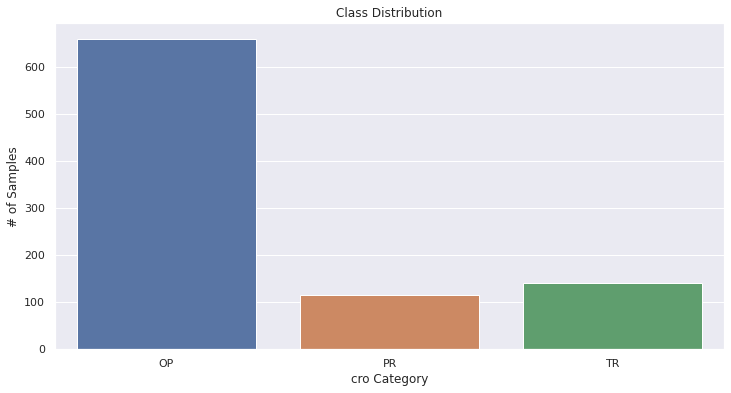

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

# Plot the number of labels of each category.
sns.countplot(x=df[CATEGORY_LEVEL])
plt.title('Class Distribution')
plt.xlabel(f'{CATEGORY_LEVEL} Category')
plt.ylabel('# of Samples')

### Document length

Calculates the length of each document in terms of WordPiece tokens

In [42]:
# Load the tokenizer.
expected_model_path = os.path.join(saved_models_path, model_id)
has_model_path = os.path.isdir(expected_model_path)
transformer_model_name = expected_model_path if has_model_path else TRANSFORMER_MODEL_NAME
tokenizer = AutoTokenizer.from_pretrained(transformer_model_name, do_lower_case=True)

def tokenize_and_count(row):
  tokens = tokenizer.tokenize(row.text)
  # Count unknown tokens --> TODO: Do they really exist with WordPiece?
  unk_no = sum('[UNK]' in token for token in tokens)
  # Count subwords from WordPiece segmentation
  subwords_no = sum(token.startswith('##') for token in tokens)
  # TODO: What's up with OOV (out of vocabulary?): They can't appear?
  return pd.Series([len(tokens), unk_no, subwords_no])

df[['token_no', 'unk_no', 'subwords_no' ]] = df.apply(lambda row: tokenize_and_count(row), axis=1)

In [43]:
print("Descriptive stats for number of tokens:\n", df.token_no.describe())
print("==================")
print("Descriptive stats for WordPiece subwords (##...):\n", df.subwords_no.describe())

Descriptive stats for number of tokens:
 count    917.00
mean     101.47
std       74.73
min        5.00
25%       53.00
50%       87.00
75%      127.00
max      839.00
Name: token_no, dtype: float64
Descriptive stats for WordPiece subwords (##...):
 count    917.00
mean       6.32
std       11.45
min        0.00
25%        2.00
50%        4.00
75%        8.00
max      207.00
Name: subwords_no, dtype: float64


Text(5.334999999999994, 0.5, '# of Documents')

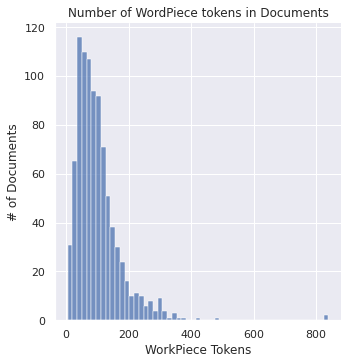

In [44]:
# Truncate text lengths greater than 512.
token_no = [min(l, 512) for l in df.token_no]
token_no = df.token_no

# Plot the distribution of comment lengths.
sns.displot(token_no, kde=False, rug=False)

plt.title('Number of WordPiece tokens in Documents')
plt.xlabel('WorkPiece Tokens')
plt.ylabel('# of Documents')

# Training

## Preparation

In [45]:
import os
import csv

def check_gpu_mem():
    '''
    Uses Nvidia's SMI tool to check the current GPU memory usage.
    Reported values are in "MiB". 1 MiB = 2^20 bytes = 1,048,576 bytes.
    '''
    
    # Run the command line tool and get the results.
    buf = os.popen('nvidia-smi --query-gpu=memory.total,memory.used --format=csv')

    # Use csv module to read and parse the result.
    reader = csv.reader(buf, delimiter=',')

    # Use a pandas table just for nice formatting.
    df_gpu = pd.DataFrame(reader)

    # Use the first row as the column headers.
    new_header = df_gpu.iloc[0] #grab the first row for the header
    df_gpu = df_gpu[1:] #take the data less the header row
    df_gpu.columns = new_header #set the header row as the df header

    return df_gpu

In [46]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

### Tokenization

In [47]:
def multi_class_tokenize(docs, labels, max_len=512):
  input_ids = []
  attention_masks = []

  for doc in docs:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            doc,                        # Doc to encode.
                            add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                            truncation = True,          # Activate truncation
                            max_length = max_len,       # Truncate to length
                            padding='max_length',       # Pad to max length 
                            return_attention_mask = True,   # Construct attn. masks
                            return_tensors = 'pt',      # Return pytorch tensors
                    )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)

  # Convert the labels to a tensor.
  torch_labels = torch.tensor(labels).long()
  # torch_labels = 
  
  return (input_ids, torch_labels, attention_masks)


# Tokenize the entire training dataset
(train_input_ids, 
 train_labels, 
 train_attention_masks) = multi_class_tokenize(docs, doc_labels, max_len = MAX_TOKEN_SIZE)

### Model initialization

In [48]:
from transformers import AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup


# Make sure that model dir exists if necessary
if not ENABLE_FINE_TUNING:
  assert expected_model_path

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = AutoModelForSequenceClassification.from_pretrained(
    TRANSFORMER_MODEL_NAME if ENABLE_FINE_TUNING else expected_model_path, # Load fresh if fine tuning is enabled
    num_labels = no_of_categories, # The number of different categories/labels
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
desc = model.cuda()

In [49]:
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = BATCH_SIZE
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = BATCH_SIZE
        )


  825 training samples
   92 validation samples


## Training loop

In [50]:
################ Training parameters ################
epochs = 4 # Number of training epochs (BERT authors recommend between 2 and 4)
lr = 2e-5
eps = 1e-8
max_grad_norm = 1.0
num_warmup_steps = 0 # TODO: Try out 100?
#####################################################

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Initialize optimizer
optimizer = AdamW(model.parameters(),lr = lr,eps = eps)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
      optimizer, 
      num_warmup_steps = num_warmup_steps, 
      num_training_steps = total_steps
    )


# Training stats will be stored here
training_stats = []

if ENABLE_FINE_TUNING:

  # For each epoch...
  for epoch_i in range(0, epochs):
      
      # ========================================
      #               Training
      # ========================================
      
      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      # Put the model into training mode. Don't be mislead--the call to 
      # `train` just changes the *mode*, it doesn't *perform* the training.
      # `dropout` and `batchnorm` layers behave differently during training
      # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 50 batches.
          if step % 50 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)
              
              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the 
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Check GPU memory for the first couple steps.
          if SHOW_GPU_USAGE and step < 2:
              print('\n  Step {:} GPU Memory Use:'.format(step))
              df = check_gpu_mem()    
              print('    Before forward-pass: {:}'.format(df.iloc[0, 1]))

          # Always clear any previously calculated gradients before performing a
          # backward pass. PyTorch doesn't do this automatically because 
          # accumulating the gradients is "convenient while training RNNs". 
          # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
          model.zero_grad()        

          # Perform a forward pass (evaluate the model on this training batch).
          # The documentation for this `model` function is here: 
          # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
          # It returns different numbers of parameters depending on what arguments
          # arge given and what flags are set. For our useage here, it returns
          # the loss (because we provided labels) and the "logits"--the model
          # outputs prior to activation.
          loss, logits = model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask, 
                              labels=b_labels)

          # Report GPU memory use for the first couple steps.
          if SHOW_GPU_USAGE and  step < 2:
              df = check_gpu_mem()    
              print('     After forward-pass: {:}'.format(df.iloc[0, 1]))

          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value 
          # from the tensor.
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Report GPU memory use for the first couple steps.
          if SHOW_GPU_USAGE and step < 2:
              df = check_gpu_mem()    
              print('    After gradient calculation: {:}'.format(df.iloc[0, 1]))

          # Clip the norm of the gradients to prevent the exploding gradient problem
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)            
      
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epoch took: {:}".format(training_time))
          
      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      # Tracking variables 
      total_eval_accuracy = 0
      total_eval_loss = 0
      total_f1_score = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for batch in validation_dataloader:
          
          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using 
          # the `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          
          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():        

              # Forward pass, calculate logit predictions.
              # token_type_ids is the same as the "segment ids", which 
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              # The documentation for this `model` function is here: 
              # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
              # Get the "logits" output by the model. The "logits" are the output
              # values prior to applying an activation function like the softmax.
              (loss, logits) = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
              
          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          preds = np.argmax(logits, axis=1).flatten()
          labels = label_ids.flatten()

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += accuracy_score(labels, preds, normalize=True)
          total_f1_score += f1_score(labels, preds, average=F1_AVERAGING_STRATEGY)

      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # Report the final F1 score for this validation run.
      avg_f1_score =  total_f1_score / len(validation_dataloader)
      print("  F1-Score: {0:.2f}".format(avg_f1_score))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(validation_dataloader)
      
      validation_time = format_time(time.time() - t0)
      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Valid. F1': avg_f1_score,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

  print("")
  print("Training complete!")

# Else load the model from storage
else:
  pass


## Check for overfitting

In [52]:
if ENABLE_FINE_TUNING:
  # Create a DataFrame from our training statistics.
  df_stats = pd.DataFrame(data=training_stats)

  # Use the 'epoch' as the row index.
  df_stats = df_stats.set_index('epoch')
  pd.set_option('precision', 2)
  df_stats

""
epoch


In [54]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns


if ENABLE_FINE_TUNING:
  # Use plot styling from seaborn.
  sns.set(style='darkgrid')

  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)

  # Plot the learning curve.
  plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
  plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

  # Label the plot.
  plt.title("Training & Validation loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.xticks(range(1,epochs + 1))

  plt.show()

# Evaluation on Test dataset

In [55]:
# TODO: For now, we use validation. Once test set is ready, switch...

# Prepare the test dataset
# (test_input_ids, test_labels, test_attention_masks) = multi_class_tokenize(docs_test, doc_test_labels, max_len = MAX_TOKEN_SIZE)
test_data = val_dataset # TODO: replace with: TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_dataloader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=BATCH_SIZE)

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Measure elapsed time.
t0 = time.time()

# Predict 
for (step, batch) in enumerate(test_dataloader):
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))


    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store the compute graph, saving memory
    # and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Take the highest scoring output as the predicted label.
predicted_labels = np.argmax(predictions, axis=1)

In [56]:
# Calculate evaluation scores
accuracy = accuracy_score(true_labels, predicted_labels, normalize=True)
score = f1_score(true_labels, predicted_labels, average=F1_AVERAGING_STRATEGY)
print('Accuracy: {:.3}'.format(accuracy))
print('F1 score: {:.3}'.format(score))

Accuracy: 0.891
F1 score: 0.819


[Text(58.5, 0.5, 'Actual (i)'), Text(0.5, 31.5, 'Predicted (j)')]

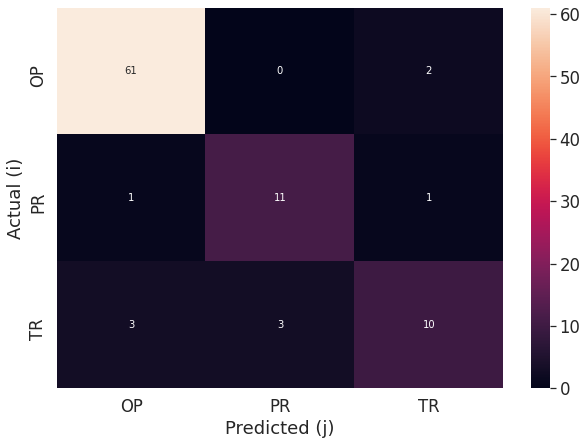

In [57]:
from sklearn.metrics import confusion_matrix

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Confusion matrix C, where C_{i,j} is equal to the number of observations known to be in group i and predicted to be in group j.
# i = 
# From https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html:
confusion_m = confusion_matrix(true_labels, predicted_labels)
df_cm = pd.DataFrame(confusion_m, index = [c for c in df[CATEGORY_LEVEL].astype('category').cat.categories],
                  columns = [c for c in df[CATEGORY_LEVEL].astype('category').cat.categories])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True)
ax.set(xlabel="Predicted (j)", ylabel="Actual (i)")


# Cleanup



## Store results

In [58]:
COLUMNS = ["model_id", "transformer_model", "category_level", "accuracy", "f1_score", "f1_score_avg_strat", "confusion_matrix"]
RESULTS_FILE = "/content/drive/My Drive/fin-disclosures-nlp/data/labels/Firm_AnnualReport_100_results.pkl"

try:
  df_results = pd.read_pickle(RESULTS_FILE)
except FileNotFoundError:
  df_results = pd.DataFrame([], columns=COLUMNS)
  df_results = df_results.set_index('model_id')
  df_results.to_pickle(RESULTS_FILE)

new_result = pd.DataFrame([[model_id, TRANSFORMER_MODEL_NAME, CATEGORY_LEVEL, accuracy, score, F1_AVERAGING_STRATEGY, df_cm]], columns=COLUMNS)
new_result = new_result.set_index('model_id')

df_results = pd.concat([df_results[~df_results.index.isin(new_result.index)], new_result])
df_results.to_pickle(RESULTS_FILE)
df_results

,accuracy,f1_score,f1_score_avg_strat,confusion_matrix,transformer_model,category_level
model_id,,,,,,
roberta-large_cro_sub_type_combined,0.90,0.71,macro,ACUTE CHRON MARKET POLICY PROD...,roberta-large,cro_sub_type_combined
roberta-large_cro,0.93,0.90,macro,OP PR TR OP 62 0 2 PR 0 12 1 T...,roberta-large,cro
bert-base-uncased_cro_sub_type_combined,0.77,0.45,macro,ACUTE CHRON MARKET POLICY PROD...,bert-base-uncased,cro_sub_type_combined
bert-base-uncased_cro,0.89,0.82,macro,OP PR TR OP 61 0 2 PR 1 11 1 T...,bert-base-uncased,cro


## Store to drive

In [ ]:
if ENABLE_FINE_TUNING:
  # Create temporary output dir
  output_dir = f'./finetuned_models/{model_id}/'
  os.makedirs(output_dir, exist_ok=True)

  # Store model and tokenizer
  model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
  model_to_save.save_pretrained(output_dir)
  tokenizer.save_pretrained(output_dir)

  # Move to Google drive for persistance
  os.makedirs(saved_models_path, exist_ok=True)
  !cp -r $output_dir "{drive_output_dir}"
